<a href="https://colab.research.google.com/github/Zu92/nlp/blob/main/Zubieta_2b_bot_dnn_spacy_esp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 9.8 MB/s eta 0:00:00
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 23.6 MB/s eta 0:00:00


In [2]:
import json
import string
import random 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchsummary

In [3]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2023-05-22 22:58:51--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2023-05-22 22:58:51--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0s      

2023-05-22 22:58:51 (81.1 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2023-05-22 22:58:51--
Total wall clock time: 0.1s
Downloaded: 1 files, 23K in 0s (81.1 MB/s)


In [4]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [5]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [6]:
text = "personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los muercielagos'

In [7]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los muercielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[muercielagos, 'muercielago']


### 3 - Diccionario de entrada

In [8]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola! gracias por tu interes"],
             },
             {"tag": "nombre",
              "patterns": ["como los busco?","como los encuentro?"],
              "responses": ["Hola en insta somos zu3juegos_", "Somos zu3juegos_"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "coordinar", "arreglar", "hablar"],
              "responses": ["Podes escribir tu numero de a pares separados por un guion", "escribi tu numero separado de a dos en dos"]
             },
            {"tag": "envios",
              "patterns": ["¿Cúando llega?","¿llega antes de","dice que llega","tienen local","lo puedo buscar"],
              "responses": ["el envio lo hace meli, segun tu zona te deberia aparecer en la publicacion","hola no podemos adelantar las entregas ya que dependen de meli, si podes retirarlo antes","se puede retirar antes, sino el envio es que te aparece"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?"],
              "responses": ["todos los precios son los publicados, en insta somos zu3juegos_"]
             },
            {"tag": "expansion",
              "patterns": ["viene con expansiones", "este incluye expansiones", "que cambia con el que viene con expansiones"],
              "responses": ["Este juego es una edición especial preparada para jugar de a 10 jugadores, trae una cantidad de cartas de cartas similar al que viene con expansiones pero en distinta distribucion"]
             },
            {"tag": "stock",
              "patterns": ["Esto está disponible", "¿Tenes stock?", "¿Hay stock hoy?"],
              "responses": ["Hola tenemos stock, el tiempo de disponibildad aparece en la publicacion"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias","Ya compre"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "jugadores",
              "patterns": [ "es de a 10 jugadores", "cuantos jugadores","se puede jugar de menos"],
              "responses": ["esta version es de 2 a 10 jugadores"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [9]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [10]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: [' ', 'a', 'antes', 'arreglar', 'buscar', 'cambiar', 'como', 'comprar', 'con', 'contacto', 'coordinar', 'cuando', 'cuanto', 'de', 'decir', 'disponible', 'el', 'encuentro', 'este', 'expansión', 'gracias', 'haber', 'hablar', 'holar', 'hoy', 'incluir', 'jugador', 'jugar', 'llegar', 'local', 'menos', 'mucho', 'pasar', 'poder', 'precio', 'que', 'salir', 'ser', 'stock', 'tal', 'tener', 'valer', 'venir', 'ya', 'yo', 'él']
classes: ['agradecimientos', 'bienvenida', 'contacto', 'envios', 'expansion', 'jugadores', 'nombre', 'precios', 'stock']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', 'como los busco?', 'como los encuentro?', 'contacto', 'coordinar', 'arreglar', 'hablar', '¿Cúando llega?', '¿llega antes de', 'dice que llega', 'tienen local', 'lo puedo buscar', 'precio', 'Me podrás pasar los precios', '¿Cuánto vale?', '¿Cuánto sale?', 'viene con expansiones', 'este incluye expansiones', 'que cambia con el que viene con expansiones', 'Esto está disponible', '¿Tenes stock?', '¿Hay stock h

In [11]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 46


In [12]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 9


In [13]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.float32))

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(train_X, train_y)

input_dim = data_set.x.shape[1]
print("Input dim", input_dim)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim 46
Output dim 9


In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(data_set, batch_size=32, shuffle=False)

### 5 - Entrenamiento del modelo

In [16]:
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=128) # fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=64) # fully connected layer
        self.fc3 = nn.Linear(in_features=64, out_features=output_dim) # fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.softmax(self.fc3(out))
        return out

# Crear el modelo basado en la arquitectura definida
model1 = Model1(input_dim=input_dim, output_dim=output_dim)
# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

torchsummary.summary(model1, input_size=(1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           6,016
              ReLU-2               [-1, 1, 128]               0
           Dropout-3               [-1, 1, 128]               0
            Linear-4                [-1, 1, 64]           8,256
              ReLU-5                [-1, 1, 64]               0
           Dropout-6                [-1, 1, 64]               0
            Linear-7                 [-1, 1, 9]             585
           Softmax-8                 [-1, 1, 9]               0
Total params: 14,857
Trainable params: 14,857
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [17]:
from torch_helpers import categorical_acc

def train(model, train_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []

    ## Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()
            
            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error y accuracy para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
    }
    
    return history

In [18]:
history1 = train(model1,
                train_loader,
                model1_optimizer,
                model1_criterion,
                epochs=200
                )

Epoch: 1/200 - Train loss 2.195 - Train accuracy 0.133
Epoch: 2/200 - Train loss 2.196 - Train accuracy 0.167
Epoch: 3/200 - Train loss 2.194 - Train accuracy 0.233
Epoch: 4/200 - Train loss 2.195 - Train accuracy 0.167
Epoch: 5/200 - Train loss 2.196 - Train accuracy 0.267
Epoch: 6/200 - Train loss 2.195 - Train accuracy 0.233
Epoch: 7/200 - Train loss 2.193 - Train accuracy 0.233
Epoch: 8/200 - Train loss 2.194 - Train accuracy 0.200
Epoch: 9/200 - Train loss 2.193 - Train accuracy 0.200
Epoch: 10/200 - Train loss 2.193 - Train accuracy 0.167
Epoch: 11/200 - Train loss 2.191 - Train accuracy 0.167
Epoch: 12/200 - Train loss 2.191 - Train accuracy 0.233
Epoch: 13/200 - Train loss 2.193 - Train accuracy 0.200
Epoch: 14/200 - Train loss 2.191 - Train accuracy 0.233
Epoch: 15/200 - Train loss 2.191 - Train accuracy 0.167
Epoch: 16/200 - Train loss 2.190 - Train accuracy 0.200
Epoch: 17/200 - Train loss 2.192 - Train accuracy 0.167
Epoch: 18/200 - Train loss 2.190 - Train accuracy 0.267
E

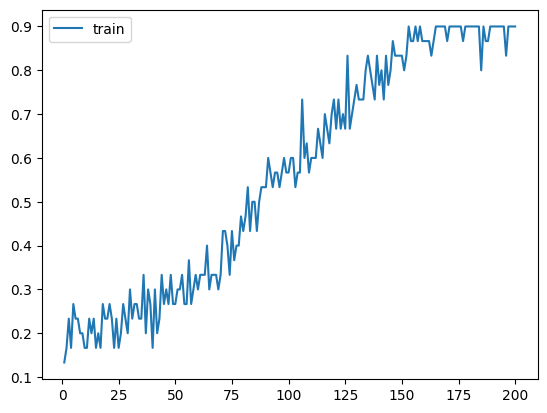

In [19]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
plt.show()

### 6 - Testing y validación

In [20]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        x = torch.from_numpy(np.array([bow]).astype(np.float32))
        result = model1(x)[0].detach().numpy()
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)

        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [21]:
message = "Hola buenos dias"
intents = pred_class(message, words, classes)
if len(intents) > 0:
    result = get_response(intents, dataset)
    print(result)

BOT: Podes escribir tu numero de a pares separados por un guion


In [22]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    

stock
BOT: Hola tenemos stock, el tiempo de disponibildad aparece en la publicacion
cuando me llega
BOT: el envio lo hace meli, segun tu zona te deberia aparecer en la publicacion
sljfoasf
Perdón, no comprendo la pregunta.
para cuantos jugadores?
BOT: esta version es de 2 a 10 jugadores
tiene expansiones
BOT: hola no podemos adelantar las entregas ya que dependen de meli, si podes retirarlo antes
viene con las expansiones
BOT: Este juego es una edición especial preparada para jugar de a 10 jugadores, trae una cantidad de cartas de cartas similar al que viene con expansiones pero en distinta distribucion
quiero agregar las expansiones
BOT: Este juego es una edición especial preparada para jugar de a 10 jugadores, trae una cantidad de cartas de cartas similar al que viene con expansiones pero en distinta distribucion
como los contacto
BOT: Hola en insta somos zu3juegos_
Gracias
BOT: Por nada!, cualquier otra consulta podes escribirme
ya hice la compra
BOT: Por nada!, cualquier otra consu

KeyboardInterrupt: ignored

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar multi label classification:\
https://machinelearningmastery.com/multi-label-classification-with-deep-learning/
- Utilizar TF-IDF en vez de bag of words